# RL solution for DMBAR problem
This is the DMBAR RL Model with KPI plotting. WE start by creating the environment DMBAR. The RL agent is trained on real-time generated ride requests. PPO and Actor-Critic setup have been used. Both Training and testing KPIs have been plotted for better understanding of the performance of the agent

--- Starting Training for 250 epochs (Action Dim: 61)---

--- Request 0 (T=0.86) ---
  Request Details: Origin=8, Dest=0, Size=10, Earliest=0.86, Latest=3.30, Modules Needed=2
  Decision Taken: Action: V9: ASSIGN_DIRECT, Cost: 3.16, Served: True

--- Request 1 (T=2.94) ---
  Request Details: Origin=5, Dest=1, Size=22, Earliest=2.94, Latest=8.98, Modules Needed=5
  Decision Taken: Action: GLOBAL: REJECT, Cost: 2200.00, Served: False

--- Request 2 (T=3.88) ---
  Request Details: Origin=4, Dest=11, Size=2, Earliest=3.88, Latest=6.33, Modules Needed=1
  Decision Taken: Action: V3: SPLIT_ASSIGN, Cost: 4.43, Served: True

--- Request 3 (T=4.17) ---
  Request Details: Origin=4, Dest=5, Size=12, Earliest=4.17, Latest=8.13, Modules Needed=3
  Decision Taken: Action: V3: MERGE_ASSIGN, Cost: 5.90, Served: True

--- Request 4 (T=4.52) ---
  Request Details: Origin=4, Dest=7, Size=9, Earliest=4.52, Latest=12.61, Modules Needed=2
  Decision Taken: Action: V5: ASSIGN_DIRECT, Cost: 3.37, Served: True

/tmp/ipython-input-1294199567.py:503: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  states = torch.tensor([t.state for t in transitions], dtype=torch.float32, device=device)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  Decision Taken: Action: V7: SPLIT_ASSIGN, Cost: 4.37, Served: True

--- Request 252 (T=247.48) ---
  Request Details: Origin=8, Dest=10, Size=10, Earliest=247.48, Latest=253.50, Modules Needed=2
  Decision Taken: Action: V7: SPLIT_ASSIGN, Cost: 3.14, Served: True

--- Request 253 (T=247.83) ---
  Request Details: Origin=8, Dest=3, Size=14, Earliest=247.83, Latest=251.57, Modules Needed=3
  Decision Taken: Action: V6: SPLIT_ASSIGN, Cost: 3.51, Served: True

--- Request 254 (T=247.93) ---
  Request Details: Origin=5, Dest=3, Size=14, Earliest=247.93, Latest=256.70, Modules Needed=3
  Decision Taken: Action: V1: ASSIGN_DIRECT, Cost: 1.51, Served: True

--- Request 255 (T=248.03) ---
  Request Details: Origin=9, Dest=6, Size=23, Earliest=248.03, Latest=252.70, Modules Needed=5
  Decision Taken: Action: GLOBAL: REJECT, Cost: 2300.00, Served: False

--- Request 256 (T=249.03) ---
  Request Details: Origin=10, Des

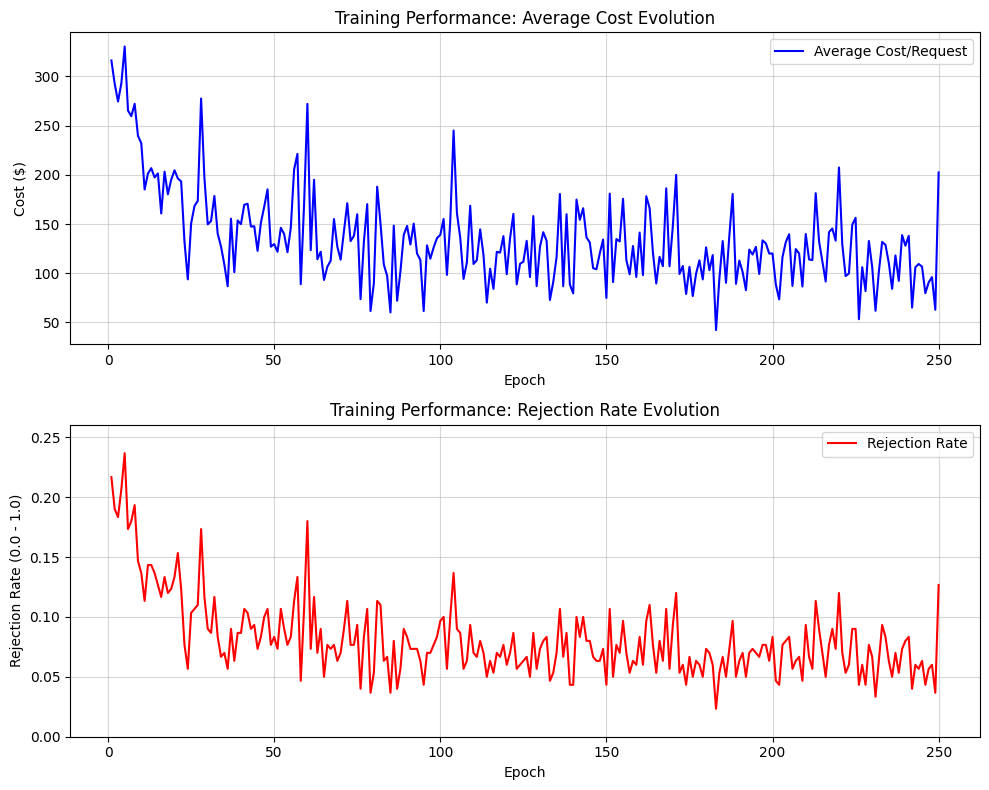


--- Starting Testing for 20 episodes ---
✅ Testing finished. KPI data collected.

                      KEY PERFORMANCE INDICATORS (KPIs)                  
Total Requests Processed: 10000
------------------------------------------------------------
1. Rejection Rate:                      0.0984
2. Average Total Cost per Request: $162.95
------------------------------------------------------------
3. Avg. Customer Waiting Time (Served): 3.27 time units
4. Avg. Vehicle Occupancy Rate (Served): 0.8121
------------------------------------------------------------
5. Service Action Distribution (Served):
   - Direct Assignments: 45.87%
   - Split Assignments:  26.71%
   - Merge Assignments:  27.42%
------------------------------------------------------------
6. Avg. Active Vehicles in System: 6.16 / 20
7. Avg. Total Modules in Use:      20.00 / 20


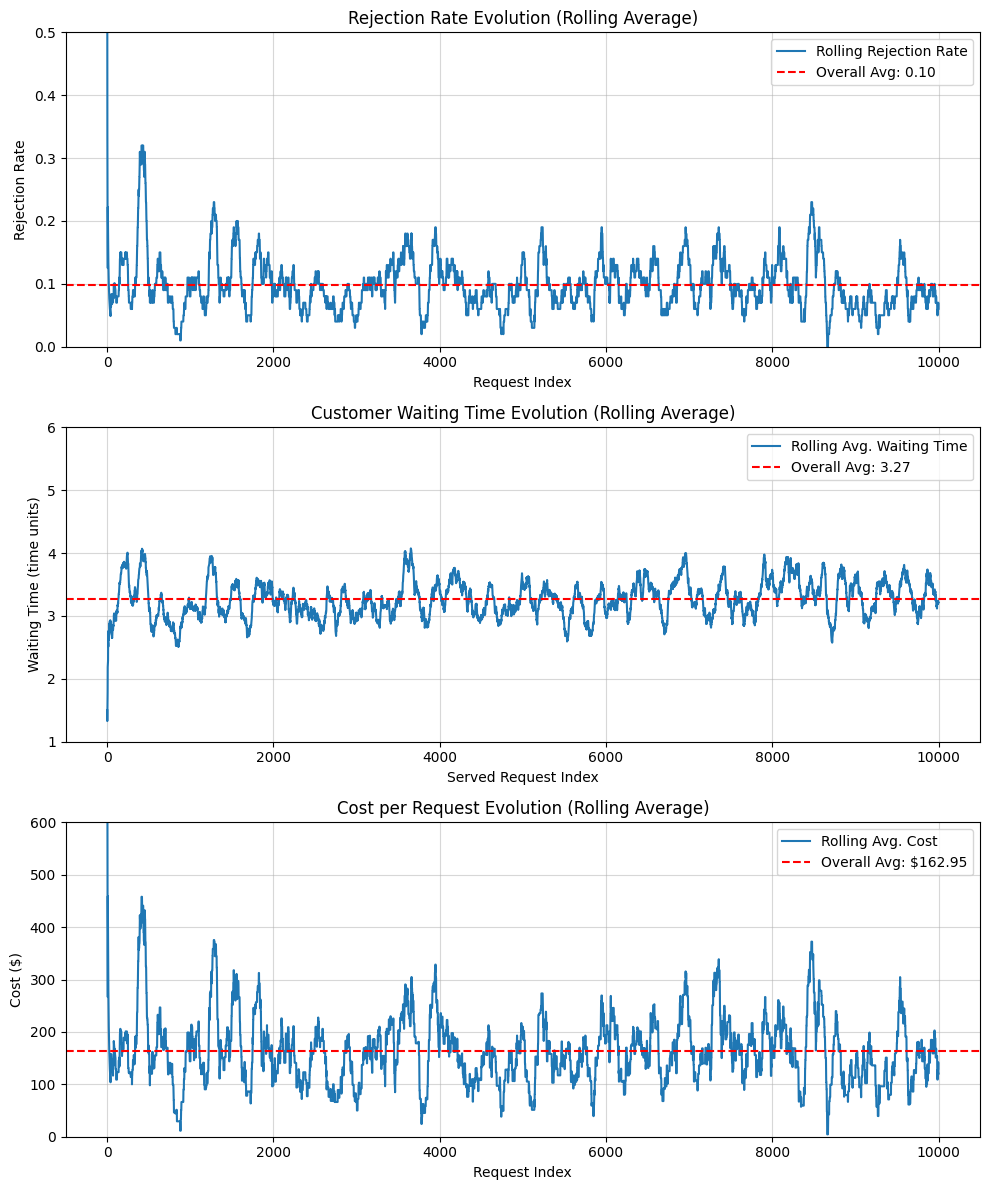

In [ ]:
import random
import math
import time as pytime
from collections import namedtuple
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# -------------------------
# Environment: Directed graph, real-time requests
# -------------------------
class Vehicle:
    def __init__(self, vid, tavail=0.0, pavail=0, m=0, config=None):
        self.vid = vid
        self.tavail = tavail
        self.pavail = pavail
        self.m = m
        self.config = [] if config is None else config

    def copy(self):
        return Vehicle(self.vid, self.tavail, self.pavail, self.m, list(self.config))

class Request:
    def __init__(self, origin, dest, te, tl, n, route=None):
        self.or_ = origin
        self.dr = dest
        self.te = te
        self.tl = tl
        self.n = n
        self.Pr = route
        self.t_pickup_actual = None
        self.t_wait = None
        self.t_ride = None

class DirectedNetwork:
    def __init__(self, n_nodes=26, seed=0):
        self.n = n_nodes
        random.seed(seed)
        np.random.seed(seed)
        self.G = nx.DiGraph()
        for i in range(n_nodes):
            self.G.add_node(i)
        for i in range(n_nodes):
            self.G.add_edge(i, (i+1) % n_nodes, weight=1.0)
        for _ in range(max(1, n_nodes // 2) * n_nodes):
            a, b = random.randrange(n_nodes), random.randrange(n_nodes)
            if a != b and not self.G.has_edge(a, b):
                self.G.add_edge(a, b, weight=random.uniform(0.5, 2.0))
    def travel_time(self, a, b):
        try:
            return nx.shortest_path_length(self.G, a, b, weight='weight')
        except nx.NetworkXNoPath:
            return float('inf')

class DMBAREnv:

    def __init__(self, network, depots, num_modules=5, Cm=5, seed=0):
        self.net = network
        self.depots = depots
        self.num_modules = num_modules
        self.Cm = Cm
        self.max_time = 10000.0
        self.max_request_n = 25
        self.max_vehicle_slots = 20
        self.num_initial_vehicles = 10
        self.total_initial_modules = 20
        self.crej = 100.0
        self.cop = 1.0
        self.cwait = 0.3
        self.creconf = 1.0
        self.cmerge = 0.5
        self.split_time = 0.5
        self.merge_time = 0.5

        # --- FIX: Action Space Definition for Global Reject ---
        self.ACTIONS_PER_VEHICLE = 3  # (0: Direct, 1: Split, 2: Merge)
        self.GLOBAL_ACTIONS = 1       # (Single Global Reject)
        self.ACTION_DIM = (self.ACTIONS_PER_VEHICLE * self.max_vehicle_slots) + self.GLOBAL_ACTIONS # 61 total actions
        self.GLOBAL_REJECT_INDEX = self.ACTION_DIM - 1 # Index 60
        # ------------------------------------------------------

        random.seed(seed)
        np.random.seed(seed)
        self.reset()

    def reset(self, request_stream=None):
        self.time = 0.0
        self.vehicles = []
        self.next_module_id = 0
        all_module_ids = list(range(self.total_initial_modules))
        random.shuffle(all_module_ids)
        vehicle_configs = [[] for _ in range(self.num_initial_vehicles)]
        if request_stream is None:
            # Fallback for training/standalone testing if needed
            self._build_request_stream(length=500)
        else:
            # Crucial step: use the provided stream
            self.requests = request_stream

        self.req_index = 0
        v_index = 0
        for module_id in all_module_ids:
            while len(vehicle_configs[v_index % self.num_initial_vehicles]) >= self.num_modules:
                v_index += 1
            vehicle_configs[v_index % self.num_initial_vehicles].append(module_id)
            v_index += 1
        for i in range(self.num_initial_vehicles):
            config = vehicle_configs[i]
            depot_index = i % len(self.depots)
            v = Vehicle(vid=i, tavail=0.0, pavail=self.depots[depot_index], m=len(config), config=config)
            self.vehicles.append(v)
        self.next_module_id = self.total_initial_modules

        # Ensure we pad up to max_vehicle_slots with inactive vehicles (m=0, vid is next index)
        for i in range(self.num_initial_vehicles, self.max_vehicle_slots):
            self.vehicles.append(Vehicle(vid=i, tavail=0.0, pavail=self.depots[0], m=0, config=[]))

        self._build_request_stream()
        self.req_index = 0
        obs, mask = self._get_obs_and_mask()
        return obs, mask

    def _build_request_stream(self, length=500):
        seq = []
        t = 0.0
        for _ in range(length):
            t += max(0.1, np.random.exponential(1.0))
            if t > self.max_time: break
            o, d = random.randrange(self.net.n), random.randrange(self.net.n)
            while d == o: d = random.randrange(self.net.n)
            n = random.randint(1, self.max_request_n)
            te = t
            tl = t + random.uniform(2.0, 10.0)
            seq.append(Request(o, d, te, tl, n))
        self.requests = seq

    def _current_request(self):
        return self.requests[self.req_index] if self.req_index < len(self.requests) else None

    def _state_dim(self):
        vfeat = 1 + self.net.n + 1
        rfeat = self.net.n * 2 + 3
        return self.max_vehicle_slots * vfeat + rfeat

    def _encode_state(self, req=None):
        vec = []
        for v in self.vehicles:
            vec.append((v.tavail - self.time) / (self.max_time + 1e-6))
            onehot = [0.0] * self.net.n
            onehot[v.pavail] = 1.0
            vec.extend(onehot)
            vec.append(v.m / self.num_modules)


        if req is None:
            vec.extend([0.0] * (self.net.n*2 + 3))
        else:
            or_oh, dr_oh = [0.0]*self.net.n, [0.0]*self.net.n
            or_oh[req.or_], dr_oh[req.dr] = 1.0, 1.0
            vec.extend(or_oh + dr_oh)
            vec.append(req.n / (self.Cm * self.num_modules))
            vec.append((req.te - self.time)/(self.max_time + 1e-6))
            vec.append((req.tl - self.time)/(self.max_time + 1e-6))
        return np.array(vec, dtype=np.float32)

    def _get_obs_and_mask(self):
        req = self._current_request()
        return self._encode_state(req), self.compute_mask(req)

    def compute_mask(self, req):
        # nA is 61
        nA = self.ACTION_DIM
        mask = np.zeros(nA, dtype=np.float32)

        # Always enable the single Global Reject action
        mask[self.GLOBAL_REJECT_INDEX] = 1.0

        if req is None:
            return mask

        needed = math.ceil(req.n / self.Cm)
        has_inactive_slot = any(v.m == 0 for v in self.vehicles)
        t_start_reposition = max(self.time, 0.0)

        for i, v in enumerate(self.vehicles):
            # Base index for vehicle i: 3 * i
            base_idx = self.ACTIONS_PER_VEHICLE * i

            # Action 0: assign_direct (Index 3*i)
            t_to_origin = self.net.travel_time(v.pavail, req.or_)
            t_start_direct = max(v.tavail, t_start_reposition)
            t_pickup_direct = t_start_direct + t_to_origin
            is_direct_time_feasible = (t_pickup_direct <= req.tl)

            if v.m >= needed and is_direct_time_feasible:
                mask[base_idx + 0] = 1.0

            # Action 1: split_assign (Index 3*i + 1)
            t_split_finish = max(v.tavail, t_start_reposition) + self.split_time
            t_pickup_split = t_split_finish + t_to_origin
            is_split_time_feasible = (t_pickup_split <= req.tl)
            if v.m > needed and has_inactive_slot and is_split_time_feasible:
                mask[base_idx + 1] = 1.0

            # Action 2: merge_assign (Index 3*i + 2)
            if v.m > 0 and v.m < needed:
                can_find_feasible_partner = False
                t_arrival_v_at_origin = max(v.tavail, t_start_reposition) + t_to_origin

                # Check for feasible partners
                for j, v_other in enumerate(self.vehicles):
                    # Check: not the same vehicle, partner must be active, capacity is enough
                    if i != j and v_other.m > 0 and (v.m + v_other.m >= needed):
                        t_to_origin_other = self.net.travel_time(v_other.pavail, req.or_)
                        t_arrival_other_at_origin = max(v_other.tavail, t_start_reposition) + t_to_origin_other
                        t_merge_start = max(t_arrival_v_at_origin, t_arrival_other_at_origin)
                        t_pickup_merge = t_merge_start + self.merge_time
                        if t_pickup_merge <= req.tl:
                            can_find_feasible_partner = True
                            break
                if can_find_feasible_partner:
                    mask[base_idx + 2] = 1.0

        return mask

    def step(self, action):
        info = {}
        req = self._current_request()
        if req is None:
            # Done logic remains the same
            obs = self._encode_state(None)
            # Must return the mask for the next (None) state
            return obs, self.compute_mask(None), 0.0, True, info

        served = True
        cost = 0.0
        needed = math.ceil(req.n / self.Cm)
        self.time = max(self.time, req.te)
        t_start_reposition = self.time
        t_pickup, t_ride = 0.0, 0.0
        v = None # Vehicle reference

        # --- Decode Action Based on Global Reject ---
        if action == self.GLOBAL_REJECT_INDEX:
            # Action is the Global Reject
            a_type = 3 # Use 3 as the internal identifier for Reject
            i = -1     # Dummy index
        else:
            # Action is vehicle-specific (Direct, Split, or Merge)
            i = action // self.ACTIONS_PER_VEHICLE
            a_type = action % self.ACTIONS_PER_VEHICLE # 0, 1, or 2
            v = self.vehicles[i]
        # -------------------------------------------------

        if a_type == 0:  # assign_direct
            t_to_origin = self.net.travel_time(v.pavail, req.or_)
            t_ride = self.net.travel_time(req.or_, req.dr)
            t_start_direct = max(v.tavail, t_start_reposition)
            t_pickup = t_start_direct + t_to_origin
            t_arrival = t_pickup + t_ride
            cost = self.cop * (t_to_origin + t_ride)
            v.tavail = t_arrival
            v.pavail = req.dr
            info['action_type'] = 'direct'

        elif a_type == 1:  # split_assign
            v_child = next((slot for slot in self.vehicles if slot.m == 0), None)
            if v_child is None:
                # This should be prevented by the mask, but handle as safety: convert to Reject
                cost, a_type, served = self.crej * req.n, 3, False
                info['action_type'] = 'reject'
            else:
                t_to_origin = self.net.travel_time(v.pavail, req.or_)
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_split_finish = max(v.tavail, t_start_reposition) + self.split_time
                t_pickup = t_split_finish + t_to_origin
                t_arrival = t_pickup + t_ride
                cost = self.creconf + self.cop * (t_to_origin + t_ride)
                child_config = v.config[:needed]
                parent_config = v.config[needed:]
                v.m, v.config, v.tavail = len(parent_config), parent_config, t_split_finish
                v_child.m, v_child.config, v_child.pavail, v_child.tavail = len(child_config), child_config, req.dr, t_arrival
                info['action_type'] = 'split'

        elif a_type == 2:  # merge_assign
            best_partner = None
            min_merge_start_time = float('inf')
            t_to_origin_v = self.net.travel_time(v.pavail, req.or_)
            t_arrival_v = max(v.tavail, t_start_reposition) + t_to_origin_v
            best_partner_to_origin_travel = 0.0

            # Re-find the best partner (necessary as info is not passed from mask)
            for v_other in self.vehicles:
                if v_other.vid == v.vid or v_other.m == 0: continue
                if v.m + v_other.m >= needed:
                    t_to_origin_other = self.net.travel_time(v_other.pavail, req.or_)
                    t_arrival_other = max(v_other.tavail, t_start_reposition) + t_to_origin_other
                    t_merge_start = max(t_arrival_v, t_arrival_other)
                    t_pickup_merge = t_merge_start + self.merge_time
                    if t_pickup_merge <= req.tl and t_merge_start < min_merge_start_time:
                        min_merge_start_time, best_partner, best_partner_to_origin_travel = t_merge_start, v_other, t_to_origin_other

            if best_partner is None:
                # This should be prevented by the mask, but handle as safety: convert to Reject
                cost, a_type, served = self.crej * req.n, 3, False
                info['action_type'] = 'reject'
            else:
                v_other = best_partner
                t_merge_start = min_merge_start_time
                t_pickup = t_merge_start + self.merge_time
                t_ride = self.net.travel_time(req.or_, req.dr)
                t_arrival = t_pickup + t_ride
                op_cost_v = self.cop * t_to_origin_v
                op_cost_other = self.cop * best_partner_to_origin_travel
                op_cost_ride = self.cop * t_ride
                cost = self.creconf + self.cmerge + op_cost_v + op_cost_other + op_cost_ride
                v.config = v.config + v_other.config
                v.m, v.tavail, v.pavail = v.m + v_other.m, t_arrival, req.dr
                v_other.m, v_other.config, v_other.tavail, v_other.pavail = 0, [], t_merge_start, req.or_
                info['action_type'] = 'merge'

        else:  # a_type == 3, Global Reject
            cost, served = self.crej * req.n, False
            info['action_type'] = 'reject'

        reward = -cost
        info['cost'] = cost

        # --- KPI Data Capture ---
        if served:
            info['wait_time'] = max(0.0, t_pickup - req.te)
            info['vehicle_occupancy_rate'] = req.n / (needed * self.Cm)
        else:
            info['wait_time'] = 0.0
            info['vehicle_occupancy_rate'] = 0.0

        info['is_rejected'] = (a_type == 3)
        info['request_size'] = req.n
        info['request_module_needed'] = needed
        info['num_active_vehicles'] = sum(1 for vh in self.vehicles if vh.m > 0)
        info['total_modules_active'] = sum(vh.m for vh in self.vehicles)

        self.req_index += 1
        next_req = self._current_request()
        done = next_req is None
        obs, next_mask = self._encode_state(next_req), self.compute_mask(next_req)

        return obs, next_mask, reward, done, info

# -------------------------
# PPO Model and Utility
# -------------------------
class MaskedCategorical(torch.distributions.Categorical):
    def __init__(self, logits, mask):
        very_neg = -1e9
        masked_logits = torch.where(mask > 0.5, logits, torch.full_like(logits, very_neg))
        super().__init__(logits=masked_logits)

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=256):
        super().__init__()
        self.actor = nn.Sequential(nn.Linear(state_dim, hidden), nn.ReLU(),
                                     nn.Linear(hidden, hidden//2), nn.ReLU(),
                                     nn.Linear(hidden//2, action_dim))
        self.critic = nn.Sequential(nn.Linear(state_dim, hidden), nn.ReLU(),
                                           nn.Linear(hidden, hidden//2), nn.ReLU(),
                                           nn.Linear(hidden//2, 1))
    def forward(self, x):
        return self.actor(x), self.critic(x).squeeze(-1)

Transition = namedtuple('Transition', ['state','mask','action','logp','reward','value','done'])

def compute_gae(transitions, last_value, gamma=0.99, lam=0.95):
    rewards = [t.reward for t in transitions]
    values = [t.value for t in transitions]
    dones = [t.done for t in transitions]
    advs, gae = [], 0.0
    for i in reversed(range(len(rewards))):
        nxt = last_value if i == len(rewards)-1 else values[i+1]
        mask = 0.0 if dones[i] else 1.0
        delta = rewards[i] + gamma * nxt * mask - values[i]
        gae = delta + gamma * lam * mask * gae
        advs.insert(0, gae)
    returns = [advs[i] + values[i] for i in range(len(advs))]
    return advs, returns

# -------------------------
# NEW: Logging and Verification Helpers
# -------------------------
def action_to_str(action_index):
    """Converts the action index to a human-readable string based on the new 61-action space."""

    ACTIONS_PER_VEHICLE = 3

    # Check if it's the global reject action (Index 60)
    if action_index == (20 * ACTIONS_PER_VEHICLE):
        return "GLOBAL: REJECT"

    vehicle_idx = action_index // ACTIONS_PER_VEHICLE
    action_type = action_index % ACTIONS_PER_VEHICLE

    type_map = {0: "ASSIGN_DIRECT", 1: "SPLIT_ASSIGN", 2: "MERGE_ASSIGN"}
    action_name = type_map.get(action_type, "UNKNOWN")

    return f"V{vehicle_idx}: {action_name}"

def print_action_details(step_num, req, action_index, info):
    """Prints the request details, action taken, and cost."""
    action_str = action_to_str(action_index)
    cost = info['cost']
    served = not info['is_rejected']

    # Format the request attributes
    req_attrs = (
        f"Origin={req.or_}, Dest={req.dr}, Size={req.n}, "
        f"Earliest={req.te:.2f}, Latest={req.tl:.2f}, "
        f"Modules Needed={info.get('request_module_needed', 'N/A')}"
    )

    # Format the action and cost details
    action_details = f"Action: {action_str}, Cost: {cost:.2f}, Served: {served}"

    print(f"\n--- Request {step_num} (T={info['time']:.2f}) ---")
    print(f"  Request Details: {req_attrs}")
    print(f"  Decision Taken: {action_details}")

# -------------------------
# PPO Training Loop
# -------------------------
def train(model_path="ppo_dmbar_model.pth"):
    net = DirectedNetwork(n_nodes=12, seed=1)
    depots = [0, 6]
    env = DMBAREnv(net, depots, num_modules=5, Cm=5, seed=1)

    state_dim = env._state_dim()
    # ACTION_DIM is now 61
    action_dim = env.ACTION_DIM
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ActorCritic(state_dim, action_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)

    epochs, steps_per_epoch = 250, 2048
    gamma, lam, clip_eps = 0.99, 0.95, 0.2
    ent_coef, value_coef = 0.05, 0.5
    max_grad_norm = 0.5

    # ------- Training Log List -----
    log_data = []
    # --------------------------------

    print(f"--- Starting Training for {epochs} epochs (Action Dim: {action_dim})---")
    for ep in range(epochs):
        transitions, steps, total_cost, total_rejects = [], 0, 0.0, 0
        obs, mask = env.reset()
        env._build_request_stream(length=steps_per_epoch)
        env.req_index = 0
        done = False

        while not done and steps < steps_per_epoch:
            s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            mask_t = torch.tensor(mask, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                logits, value = model(s)
                dist = MaskedCategorical(logits=logits, mask=mask_t)
                a = dist.sample().item()
                logp = dist.log_prob(torch.tensor(a, device=device)).item()
                v = value.item()

            current_req = env._current_request()
            next_obs, next_mask, reward, done, info = env.step(a)

            # --- Printing Logic for Verification ---
            if current_req:
                info['time'] = env.time
                print_action_details(
                    steps,
                    current_req,
                    a,
                    info
                )
            # --- End Printing Logic ---

            transitions.append(Transition(obs, mask, a, logp, reward, v, done))
            obs, mask = next_obs, next_mask
            total_cost += -reward
            if info['is_rejected']: total_rejects += 1
            steps += 1

        # PPO update
        last_val = 0.0
        if not done and steps > 0:
            s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad(): _, val = model(s); last_val = val.item()

        if steps > 0:
            advs, returns = compute_gae(transitions, last_val, gamma, lam)
            states = torch.tensor([t.state for t in transitions], dtype=torch.float32, device=device)
            masks = torch.tensor([t.mask for t in transitions], dtype=torch.float32, device=device)
            actions = torch.tensor([t.action for t in transitions], dtype=torch.long, device=device)
            old_logps = torch.tensor([t.logp for t in transitions], dtype=torch.float32, device=device)
            advantages = torch.tensor(advs, dtype=torch.float32, device=device)
            returns_t = torch.tensor(returns, dtype=torch.float32, device=device)
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            for _ in range(4):
                logits, values = model(states)
                dists = MaskedCategorical(logits=logits, mask=masks)
                new_logps = dists.log_prob(actions)
                entropy = dists.entropy().mean()
                ratio = torch.exp(new_logps - old_logps)
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = (returns_t - values).pow(2).mean()
                loss = actor_loss + value_coef * critic_loss - ent_coef * entropy

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()

            avg_cost = total_cost / steps
            reject_rate = total_rejects / steps

            # ----- Log the data for the current epoch ---
            log_data.append({
                'epoch': ep + 1,
                'avg_cost': avg_cost,
                'reject_rate': reject_rate
            })
            # -----------------------------------------------

            print(f"Epoch {ep+1}/{epochs}: Avg. Cost/Req={avg_cost:.2f}, Reject Rate={reject_rate:.3f}")

    torch.save(model.state_dict(), model_path)
    print(f"\n✅ Training finished. Model saved to '{model_path}'")

    df_train_log = pd.DataFrame(log_data)
    return model, df_train_log

# -------------------------
# Plotting and Testing Functions
# -------------------------
def plot_train_kpis(df_train_log):
    """Generates plots for the evolution of training performance."""
    if df_train_log.empty:
        print("No training log data to plot.")
        return

    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Plot 1: Average Cost Evolution
    axes[0].plot(df_train_log['epoch'], df_train_log['avg_cost'], label='Average Cost/Request', color='blue')
    axes[0].set_title('Training Performance: Average Cost Evolution')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Cost ($)')
    axes[0].grid(True, alpha=0.5)
    axes[0].legend()

    # Plot 2: Rejection Rate Evolution
    axes[1].plot(df_train_log['epoch'], df_train_log['reject_rate'], label='Rejection Rate', color='red')
    axes[1].set_title('Training Performance: Rejection Rate Evolution')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Rejection Rate (0.0 - 1.0)')
    axes[1].set_ylim(0, df_train_log['reject_rate'].max() * 1.1)
    axes[1].grid(True, alpha=0.5)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def load_model(model_path, state_dim, action_dim):
    """Loads a trained model from a file."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ActorCritic(state_dim, action_dim).to(device)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
        print(f"Model loaded successfully from {model_path}.")
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Please train first.")
        return None
    return model

def test(model, env, num_episodes=20, request_stream_length=500):
    """Evaluates the trained model and collects KPIs."""
    device = next(model.parameters()).device
    model.eval()
    test_log_data = []

    print(f"\n--- Starting Testing for {num_episodes} episodes ---")
    for ep in range(num_episodes):
        obs, mask = env.reset()
        env._build_request_stream(length=request_stream_length)
        env.req_index = 0
        done = False
        steps = 0

        while not done:
            s = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            mask_t = torch.tensor(mask, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                logits, _ = model(s)
                dist = MaskedCategorical(logits=logits, mask=mask_t)
                a = dist.sample().item()

            current_req = env._current_request()
            next_obs, next_mask, reward, done, info = env.step(a)

            if current_req:
                test_log_data.append({
                    'episode': ep, 'step': steps, 'time': env.time,
                    'action_type': info['action_type'], 'cost': info['cost'],
                    'is_rejected': info['is_rejected'],
                    'wait_time': info['wait_time'],
                    'request_size': info['request_size'],
                    'occupancy_rate': info['vehicle_occupancy_rate'],
                    'num_active_vehicles': info['num_active_vehicles'],
                    'total_modules_active': info['total_modules_active']
                })

            obs, mask = next_obs, next_mask
            steps += 1

    df_test_log = pd.DataFrame(test_log_data)
    print("✅ Testing finished. KPI data collected.")
    return df_test_log

def calculate_kpis(df_test_log, env):
    """Calculates and prints the Key Performance Indicators."""
    total_requests = len(df_test_log)
    if total_requests == 0:
        return "No requests processed in the test log."

    df_served = df_test_log[df_test_log['is_rejected'] == False]
    num_served = len(df_served)

    kpis = {}

    # 1. Rejection Rate
    rejection_rate = df_test_log['is_rejected'].sum() / total_requests
    kpis['Rejection Rate'] = rejection_rate

    # 2. Average Cost
    kpis['Average Total Cost per Request'] = df_test_log['cost'].sum() / total_requests

    # 3. Customer Waiting Time
    avg_wait_time = df_served['wait_time'].mean() if num_served > 0 else 0.0
    kpis['Average Customer Waiting Time'] = avg_wait_time

    # 4. Vehicle Occupancy Rate (Only for served requests)
    avg_occupancy = df_served['occupancy_rate'].mean() if num_served > 0 else 0.0
    kpis['Average Vehicle Occupancy Rate'] = avg_occupancy

    # 5. Service Type Distribution
    service_counts = df_served['action_type'].value_counts(normalize=True).to_dict()
    kpis['Service Type Distribution (Direct)'] = service_counts.get('direct', 0.0)
    kpis['Service Type Distribution (Split)'] = service_counts.get('split', 0.0)
    kpis['Service Type Distribution (Merge)'] = service_counts.get('merge', 0.0)

    # 6. Resource Utilization
    kpis['Average Active Vehicles'] = df_test_log['num_active_vehicles'].mean()
    kpis['Average Active Modules'] = df_test_log['total_modules_active'].mean()

    # --- Print KPIs ---
    print("\n" + "="*60)
    print("                      KEY PERFORMANCE INDICATORS (KPIs)                  ")
    print("="*60)
    print(f"Total Requests Processed: {total_requests}")
    print("-" * 60)
    print(f"1. Rejection Rate:                      {kpis['Rejection Rate']:.4f}")
    print(f"2. Average Total Cost per Request: ${kpis['Average Total Cost per Request']:.2f}")
    print("-" * 60)
    print(f"3. Avg. Customer Waiting Time (Served): {kpis['Average Customer Waiting Time']:.2f} time units")
    print(f"4. Avg. Vehicle Occupancy Rate (Served): {kpis['Average Vehicle Occupancy Rate']:.4f}")
    print("-" * 60)
    print(f"5. Service Action Distribution (Served):")
    print(f"   - Direct Assignments: {kpis['Service Type Distribution (Direct)']:.2%}")
    print(f"   - Split Assignments:  {kpis['Service Type Distribution (Split)']:.2%}")
    print(f"   - Merge Assignments:  {kpis['Service Type Distribution (Merge)']:.2%}")
    print("-" * 60)
    print(f"6. Avg. Active Vehicles in System: {kpis['Average Active Vehicles']:.2f} / {env.max_vehicle_slots}")
    print(f"7. Avg. Total Modules in Use:      {kpis['Average Active Modules']:.2f} / {env.total_initial_modules}")
    print("="*60)

    return kpis

def plot_kpis(df_test_log, kpis):
    """Generates plots for the evolution of rejection rate and other metrics."""
    fig, axes = plt.subplots(3, 1, figsize=(10, 12))
    total_steps = df_test_log['step'] + df_test_log['episode'] * (df_test_log['step'].max() + 1)

    # ----------------------------------------------------
    # 1. Rejection Rate Evolution
    # ----------------------------------------------------
    rolling_reject_rate = df_test_log['is_rejected'].rolling(window=100, min_periods=1).mean()
    axes[0].plot(total_steps, rolling_reject_rate, label='Rolling Rejection Rate')
    axes[0].axhline(kpis['Rejection Rate'], color='r', linestyle='--', label=f'Overall Avg: {kpis["Rejection Rate"]:.2f}')
    axes[0].set_ylim(0, 0.5)
    axes[0].set_yticks(np.arange(0, 0.51, 0.1))

    axes[0].set_title('Rejection Rate Evolution (Rolling Average)')
    axes[0].set_xlabel('Request Index')
    axes[0].set_ylabel('Rejection Rate')
    axes[0].legend()
    axes[0].grid(True, alpha=0.5)

    # ----------------------------------------------------
    # 2. Waiting Time Evolution
    # ----------------------------------------------------
    df_served = df_test_log[df_test_log['is_rejected'] == False]
    served_steps = df_served['step'] + df_served['episode'] * (df_test_log['step'].max() + 1)
    rolling_wait_time = df_served['wait_time'].rolling(window=100, min_periods=1).mean()
    axes[1].plot(served_steps, rolling_wait_time, label='Rolling Avg. Waiting Time')
    axes[1].axhline(kpis['Average Customer Waiting Time'], color='r', linestyle='--', label=f'Overall Avg: {kpis["Average Customer Waiting Time"]:.2f}')
    axes[1].set_ylim(1, 6)
    axes[1].set_yticks(np.arange(1, 6.1, 1))

    axes[1].set_title('Customer Waiting Time Evolution (Rolling Average)')
    axes[1].set_xlabel('Served Request Index')
    axes[1].set_ylabel('Waiting Time (time units)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.5)

    # ----------------------------------------------------
    # 3. Average Cost Evolution
    # ----------------------------------------------------
    rolling_cost = df_test_log['cost'].rolling(window=100, min_periods=1).mean()
    axes[2].plot(total_steps, rolling_cost, label='Rolling Avg. Cost')
    axes[2].axhline(kpis['Average Total Cost per Request'], color='r', linestyle='--', label=f'Overall Avg: ${kpis["Average Total Cost per Request"]:.2f}')

    axes[2].set_ylim(0, 600)
    axes[2].set_yticks(np.arange(0, 601, 100))
    axes[2].set_title('Cost per Request Evolution (Rolling Average)')
    axes[2].set_xlabel('Request Index')
    axes[2].set_ylabel('Cost ($)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.5)

    plt.tight_layout()
    plt.show()

# -------------------------
# Execution Block: Train and Test
# -------------------------
if __name__ == "__main__":
    MODEL_FILE = "ppo_dmbar_model.pth"
    NET_NODES = 12

    # --- 1. TRAIN THE MODEL (and get the training log) ---
    trained_model, df_train_log = train(MODEL_FILE)

    # --- 2. PLOT TRAINING KPIs ---
    if trained_model:
        plot_train_kpis(df_train_log)

        # --- 3. SETUP TEST ENVIRONMENT and TEST THE MODEL ---
        net_test = DirectedNetwork(n_nodes=NET_NODES, seed=99)
        depots_test = [0, 6]
        env_test = DMBAREnv(net_test, depots_test, num_modules=5, Cm=5, seed=99)

        # --- 4. TEST THE MODEL ---
        df_test_results = test(trained_model, env_test, num_episodes=20, request_stream_length=500)

        # --- 5. CALCULATE AND PRINT TEST KPIs ---
        kpis = calculate_kpis(df_test_results, env_test)

        # --- 6. PLOT TEST KPIs ---
        plot_kpis(df_test_results, kpis)